# Pylops - interpolations of all sort

Interpolation of a signal is a big topic in mathematics and numerical analysis with lots of books and papers. In this notebook we will discuss the implementation of different interpolations in the framework of linear operators. 

What is different here is that we do not need only the operator but also its adjoint!

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import pylops

from scipy.sparse import csr_matrix, vstack, rand
from scipy.linalg import lstsq, solve, pinv
from scipy.sparse.linalg import LinearOperator as spLinearOperator
from scipy.sparse.linalg import LinearOperator, cg, lsqr

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing             import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import IRLS as IRLSpylops
from pylops.optimization.sparsity  import FISTA

Let's start by creating a signal

In [2]:
# input signal parameters
ifreqs = [41, 25, 66]
amps = [1., 1., 1.]
nt = 200
nfft = 2**11
dt = 0.004
t = np.arange(nt)*dt
f = np.fft.rfftfreq(nfft, dt)

# input signal in frequency domain
X = np.zeros(nfft//2+1, dtype='complex128')
X[ifreqs] = amps

# input signal in time domain
FFTop = pylops.signalprocessing.FFT(nt, nfft=nfft, real=True)
x = FFTop.H*X
    
# subsampling locations
perc_subsampling=0.4
ntsub=int(np.round(nt*perc_subsampling))

isample = np.arange(nt)
iava = np.sort(np.random.permutation(np.arange(nt-1))[:ntsub])
iava[-1] = nt-1

### Nearest neighbour
Let's consider nearest neighbour first, here we can both give iava or iava+0.4 and we should get the same result of the Restriction operator

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


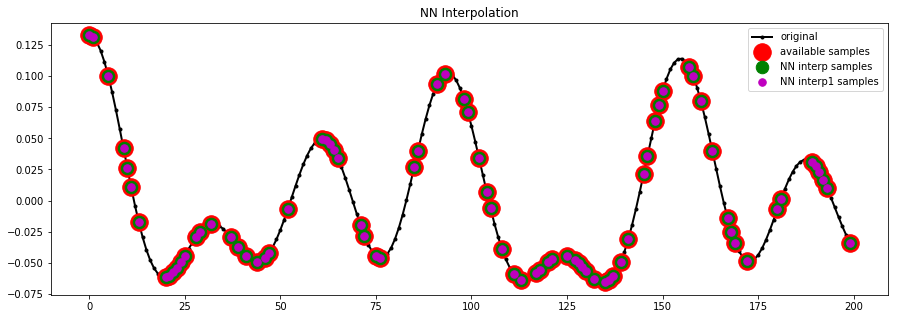

In [3]:
# Create restriction operator
Rop = Restriction(nt, iava, dtype='float64')
dottest(Rop, ntsub, nt)

# Create nearest neighbour operator
Iop, iavann = Interp(nt, iava, kind='nearest', dtype='float64')
dottest(Iop, ntsub, nt)
I1op, iavann1 = Interp(nt, iava+0.4, kind='nearest', dtype='float64')
dottest(I1op, ntsub, nt)

y     = Rop*x
yint  = Iop*x
yint1 = I1op*x
ymask = Rop.mask(x)

# Visualize data
fig = plt.figure(figsize=(15,5))
plt.plot(isample,       x,       '.-k' , LineWidth=2,   label='original')
plt.plot(iava, y,       '.r', MarkerSize=35, label='available samples')
plt.plot(iavann, yint, '.g', MarkerSize=25, label='NN interp samples')
plt.plot(iavann1, yint1, '.m', MarkerSize=15, label='NN interp1 samples')
plt.legend()
plt.title('NN Interpolation')

print(y-yint)
print(y-yint1)

### Linear intepolation
And we move now to linear intepolation. Again we should expect the same result for iava but now iava+0.4 will give different values and it will try to find the value at the exact location instead of going for the closest available sample

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

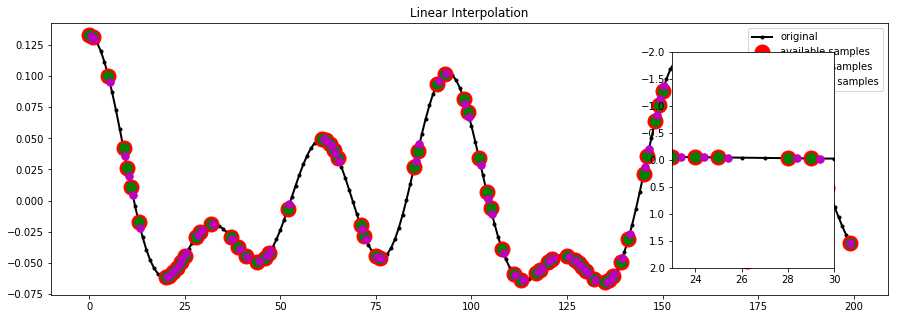

In [4]:
# Create linear interpolation operator
Iop, iavali = Interp(nt, iava, kind='linear', dtype='float64')
dottest(Iop, ntsub, nt)
I1op, iavali1 = Interp(nt, iava+0.4, kind='linear', dtype='float64')
dottest(I1op, ntsub, nt)

yint  = Iop*x
yint1 = I1op*x

# Visualize data
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(isample,       x,       '.-k' , LineWidth=2,   label='original')
ax.plot(iava, y,       '.r', MarkerSize=30, label='available samples')
ax.plot(iavali, yint, '.g', MarkerSize=20, label='NN interp samples')
ax.plot(iavali1, yint1, '.m', MarkerSize=15, label='NN interp1 samples')
ax.legend()
ax.set_title('Linear Interpolation')

subax = fig.add_axes([0.7, 0.2, 0.15, 0.6])
subax.plot(isample,       x,       '.-k' , LineWidth=2)
subax.plot(iava, y,       '.r', MarkerSize=30)
subax.plot(iavali, yint, '.g', MarkerSize=20)
subax.plot(iavali1, yint1, '.m', MarkerSize=15)
subax.set_xlim([23,30])
subax.set_ylim([2,-2])

print(y-yint)

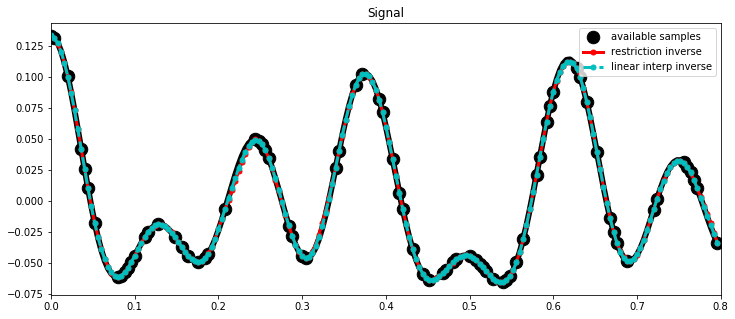

In [5]:
# regularized inversion
D2op = pylops.SecondDerivative(nt, dims=None, dtype='float64')

epsR = np.sqrt(0.1)
epsI = np.sqrt(1e-4)

xne = \
    pylops.optimization.leastsquares.NormalEquationsInversion(Rop, [D2op], y,
                                                              epsI=epsI,
                                                              epsRs=[epsR],
                                                              returninfo=False,
                                                              **dict(maxiter=50))

xneinter = \
    pylops.optimization.leastsquares.NormalEquationsInversion(I1op, [D2op], yint1,
                                                              epsI=epsI,
                                                              epsRs=[epsR],
                                                              returninfo=False,
                                                              **dict(maxiter=50))

# Visualize data
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(t, x, 'k', lw=6)
ax.plot(t, ymask, '.k', ms=25, label='available samples')
ax.plot(t, xne, '.-r', lw=3, ms=10, label='restriction inverse')
ax.plot(t, xneinter, '.--c', lw=3, ms=10, label='linear interp inverse')
ax.legend()
ax.set_title('Signal')
ax.set_xlim(0, 0.8);

## 2D signal

In [6]:
###### Input parameters
par = {'ox':0,'dx':2,    'nx':140,
       'oy':0,'dy':2,    'ny':100,
       'ot':0,'dt':0.004,'nt':200,
       'f0': 20, 'nfmax': 210}

v       = 1500
t0_m    = [0.2, 0.4, 0.5]
theta_m = [0, 30, -80]
phi_m   = [0]
amp_m   = [1., -2, 0.5]

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Generate model
m, x =  linear2d(x,t,v,t0_m,theta_m,amp_m,wav)
nx, nt = par['nx'], par['nt']

1st dim

Dot test passed, v^T(Opu)=-28.579834 - u^T(Op^Tv)=-28.579834
Dot test passed, v^T(Opu)=-64.816891 - u^T(Op^Tv)=-64.816891


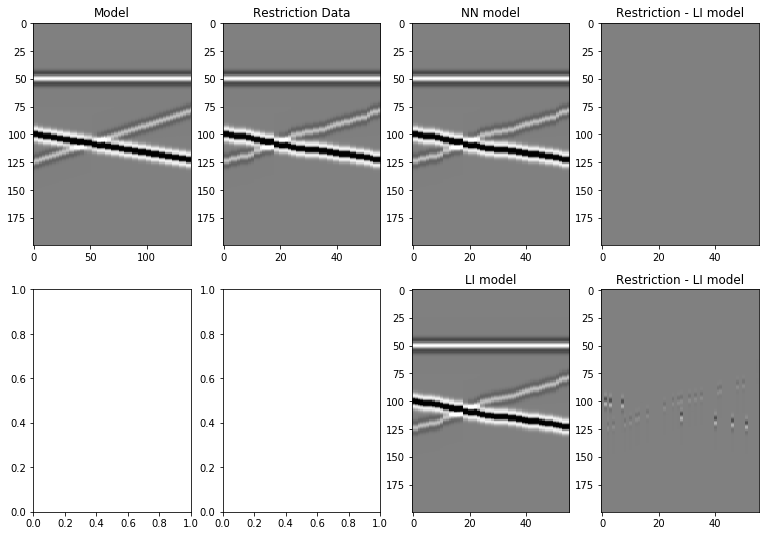

In [7]:
# Subsampling
perc_subsampling = 0.4
nxsub = int(np.round(nx*perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(nx-1))[:nxsub])
iava[-1] = nx-1

# Operators
Rop = Restriction(nx*nt, iava, dims=(nx, nt), dir=0, dtype='float64')
Innop, iavann = Interp(nx*nt, iava+0.4, dims=(nx, nt), dir=0, kind='nearest', dtype='float64')
Iliop, iavali = Interp(nx*nt, iava+0.4, dims=(nx, nt), dir=0, kind='linear', dtype='float64')
dottest(Innop, nxsub*nt, nx*nt, verb=True)
dottest(Iliop, nxsub*nt, nx*nt, verb=True)

y = (Rop*x.ravel()).reshape(nxsub, nt)
ynn = (Innop*x.ravel()).reshape(nxsub, nt)
yli = (Iliop*x.ravel()).reshape(nxsub, nt)
ymask = Rop.mask(x)


fig, axs = plt.subplots(2, 4, figsize=(13, 9))
axs[0][0].imshow(x.T, cmap='gray', vmin=-1, vmax=1)
axs[0][0].set_title('Model')
axs[0][0].axis('tight')
axs[0][1].imshow(y.T, cmap='gray', vmin=-1, vmax=1)
axs[0][1].set_title('Restriction Data')
axs[0][1].axis('tight')
axs[0][2].imshow(ynn.T, cmap='gray', vmin=-1, vmax=1)
axs[0][2].set_title('NN model')
axs[0][2].axis('tight')
axs[0][3].imshow(y.T - ynn.T, cmap='gray', vmin=-1, vmax=1)
axs[0][3].set_title('Restriction - LI model')
axs[0][3].axis('tight')
axs[1][2].imshow(yli.T, cmap='gray', vmin=-1, vmax=1)
axs[1][2].set_title('LI model')
axs[1][2].axis('tight')
axs[1][3].imshow(y.T - yli.T, cmap='gray', vmin=-1, vmax=1)
axs[1][3].set_title('Restriction - LI model')
axs[1][3].axis('tight');

Dot test passed, v^T(Opu)=-120.000909 - u^T(Op^Tv)=-120.000909
Dot test passed, v^T(Opu)=10.788930 - u^T(Op^Tv)=10.788930


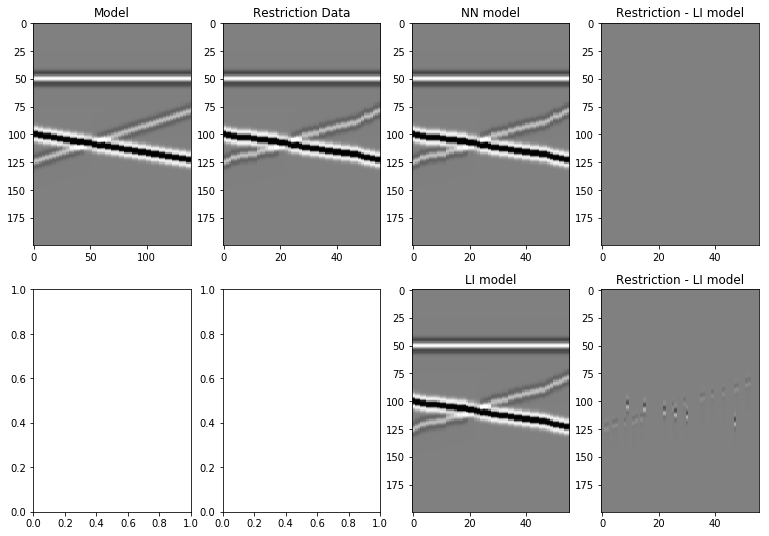

In [8]:
x1 = x.T

# Subsampling
perc_subsampling = 0.4
nxsub = int(np.round(nx*perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(nx-1))[:nxsub])
iava[-1] = nx-1

# Operators
Rop = Restriction(nx*nt, iava, dims=(nt, nx), dir=1, dtype='float64')
Innop, iavann = Interp(nx*nt, iava+0.4, dims=(nt, nx), dir=1, kind='nearest', dtype='float64')
Iliop, iavali = Interp(nx*nt, iava+0.4, dims=(nt, nx), dir=1, kind='linear', dtype='float64')
dottest(Innop, nxsub*nt, nx*nt, verb=True)
dottest(Iliop, nxsub*nt, nx*nt, verb=True)

y = (Rop*x1.ravel()).reshape(nt, nxsub)
ynn = (Innop*x1.ravel()).reshape(nt, nxsub)
yli = (Iliop*x1.ravel()).reshape(nt, nxsub)
ymask = Rop.mask(x1)


fig, axs = plt.subplots(2, 4, figsize=(13, 9))
axs[0][0].imshow(x1, cmap='gray', vmin=-1, vmax=1)
axs[0][0].set_title('Model')
axs[0][0].axis('tight')
axs[0][1].imshow(y, cmap='gray', vmin=-1, vmax=1)
axs[0][1].set_title('Restriction Data')
axs[0][1].axis('tight')
axs[0][2].imshow(ynn, cmap='gray', vmin=-1, vmax=1)
axs[0][2].set_title('NN model')
axs[0][2].axis('tight')
axs[0][3].imshow(y - ynn, cmap='gray', vmin=-1, vmax=1)
axs[0][3].set_title('Restriction - LI model')
axs[0][3].axis('tight')
axs[1][2].imshow(yli, cmap='gray', vmin=-1, vmax=1)
axs[1][2].set_title('LI model')
axs[1][2].axis('tight')
axs[1][3].imshow(y - yli, cmap='gray', vmin=-1, vmax=1)
axs[1][3].set_title('Restriction - LI model')
axs[1][3].axis('tight');

## 3d signal

In [9]:
###### Input parameters
par = {'ox':0,'dx':2,    'nx':140,
       'oy':0,'dy':2,    'ny':100,
       'ot':0,'dt':0.004,'nt':200,
       'f0': 20, 'nfmax': 210}

v       = 1500
t0_m    = [0.2, 0.4, 0.5]
theta_m = [0, 30, -80]
phi_m   = [0, 20, 40]
amp_m   = [1., -2, 0.5]

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Generate model
m, x =  linear3d(x, y ,t ,v ,t0_m, theta_m, phi_m, amp_m,wav)
ny, nx, nt = par['ny'], par['nx'], par['nt']

Dot test passed, v^T(Opu)=-1399.433452 - u^T(Op^Tv)=-1399.433452
Dot test passed, v^T(Opu)=-832.482615 - u^T(Op^Tv)=-832.482615


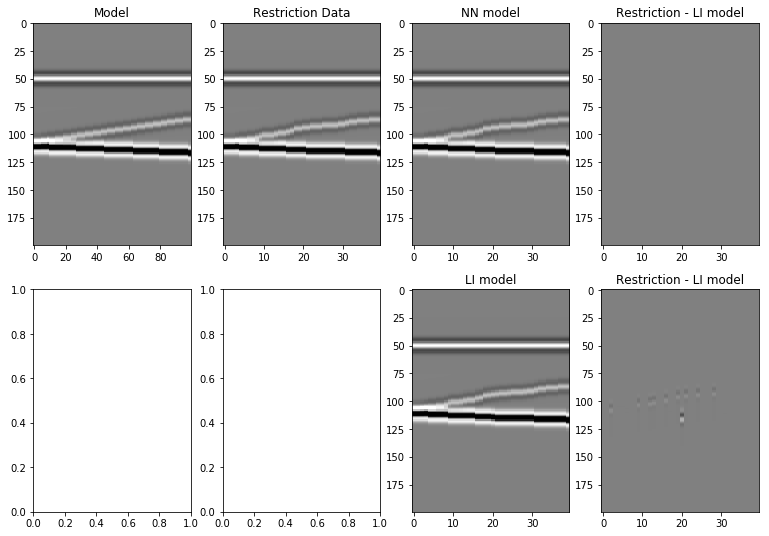

In [10]:
# Subsampling
perc_subsampling = 0.4
nysub = int(np.round(ny*perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(ny-1))[:nysub])
iava[-1] = ny-1

# Operators
Rop = Restriction(ny*nx*nt, iava, dims=(ny, nx, nt), dir=0, dtype='float64')
Innop, iavann = Interp(ny*nx*nt, iava+0.4, dims=(ny, nx, nt), dir=0, kind='nearest', dtype='float64')
Iliop, iavali = Interp(ny*nx*nt, iava+0.4, dims=(ny, nx, nt), dir=0, kind='linear', dtype='float64')
dottest(Innop, nysub*nx*nt, ny*nx*nt, verb=True)
dottest(Iliop, nysub*nx*nt, ny*nx*nt, verb=True)

y = (Rop*x.ravel()).reshape(nysub, nx, nt)
ynn = (Innop*x.ravel()).reshape(nysub, nx, nt)
yli = (Iliop*x.ravel()).reshape(nysub, nx, nt)
ymask = Rop.mask(x)


fig, axs = plt.subplots(2, 4, figsize=(13, 9))
axs[0][0].imshow(x[:, nx//2].T, cmap='gray', vmin=-1, vmax=1)
axs[0][0].set_title('Model')
axs[0][0].axis('tight')
axs[0][1].imshow(y[:, nx//2].T, cmap='gray', vmin=-1, vmax=1)
axs[0][1].set_title('Restriction Data')
axs[0][1].axis('tight')
axs[0][2].imshow(ynn[:, nx//2].T, cmap='gray', vmin=-1, vmax=1)
axs[0][2].set_title('NN model')
axs[0][2].axis('tight')
axs[0][3].imshow(y[:, nx//2].T - ynn[:, nx//2].T, cmap='gray', vmin=-1, vmax=1)
axs[0][3].set_title('Restriction - LI model')
axs[0][3].axis('tight')
axs[1][2].imshow(yli[:, nx//2].T, cmap='gray', vmin=-1, vmax=1)
axs[1][2].set_title('LI model')
axs[1][2].axis('tight')
axs[1][3].imshow(y[:, nx//2].T - yli[:, nx//2].T, cmap='gray', vmin=-1, vmax=1)
axs[1][3].set_title('Restriction - LI model')
axs[1][3].axis('tight');

Dot test passed, v^T(Opu)=-1348.210138 - u^T(Op^Tv)=-1348.210138
Dot test passed, v^T(Opu)=426.820376 - u^T(Op^Tv)=426.820376


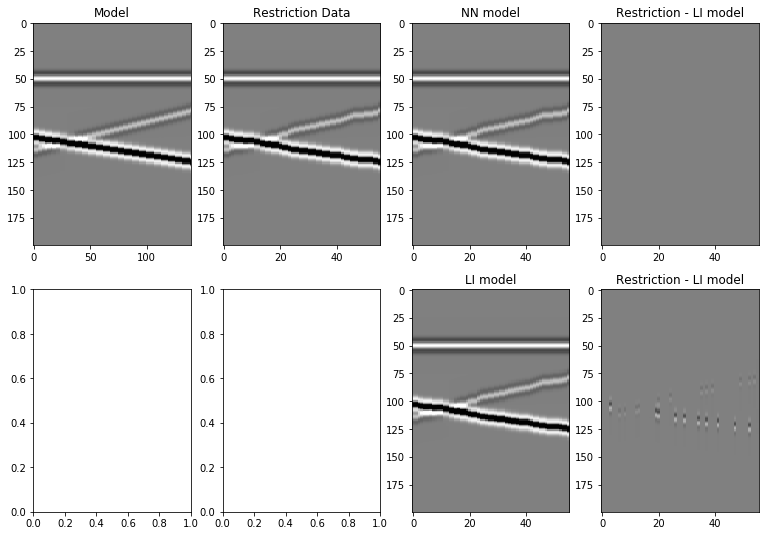

In [11]:
# Subsampling
perc_subsampling = 0.4
nxsub = int(np.round(nx*perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(nx-1))[:nxsub])
iava[-1] = nx-1

# Operators
Rop = Restriction(ny*nx*nt, iava, dims=(ny, nx, nt), dir=1, dtype='float64')
Innop, iavann = Interp(ny*nx*nt, iava+0.4, dims=(ny, nx, nt), dir=1, kind='nearest', dtype='float64')
Iliop, iavali = Interp(ny*nx*nt, iava+0.4, dims=(ny, nx, nt), dir=1, kind='linear', dtype='float64')
dottest(Innop, nxsub*ny*nt, ny*nx*nt, verb=True)
dottest(Iliop, nxsub*ny*nt, ny*nx*nt, verb=True)

y = (Rop*x.ravel()).reshape(ny, nxsub, nt)
ynn = (Innop*x.ravel()).reshape(ny, nxsub, nt)
yli = (Iliop*x.ravel()).reshape(ny, nxsub, nt)
ymask = Rop.mask(x)

fig, axs = plt.subplots(2, 4, figsize=(13, 9))
axs[0][0].imshow(x[ny//2].T, cmap='gray', vmin=-1, vmax=1)
axs[0][0].set_title('Model')
axs[0][0].axis('tight')
axs[0][1].imshow(y[ny//2].T, cmap='gray', vmin=-1, vmax=1)
axs[0][1].set_title('Restriction Data')
axs[0][1].axis('tight')
axs[0][2].imshow(ynn[ny//2].T, cmap='gray', vmin=-1, vmax=1)
axs[0][2].set_title('NN model')
axs[0][2].axis('tight')
axs[0][3].imshow(y[ny//2].T - ynn[ny//2].T, cmap='gray', vmin=-1, vmax=1)
axs[0][3].set_title('Restriction - LI model')
axs[0][3].axis('tight')
axs[1][2].imshow(yli[ny//2].T, cmap='gray', vmin=-1, vmax=1)
axs[1][2].set_title('LI model')
axs[1][2].axis('tight')
axs[1][3].imshow(y[ny//2].T - yli[ny//2].T, cmap='gray', vmin=-1, vmax=1)
axs[1][3].set_title('Restriction - LI model')
axs[1][3].axis('tight');